In [1]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

**Objective**: To build and compare a Popularity based and a Collaborative Filtering based Recommender model for a Office-Products based dataset from customer interaction on Amazon.com.

The model is inspired by [1] for recommender system construction. 

In [2]:
df= pd.read_json("../input/bigdatafinal007/Office_Products_5.json", lines=True)

In [3]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A32T2H8150OJLU,B00000JBLH,ARH,"[3, 4]","I bought my first HP12C in about 1984 or so, a...",5,"A solid performer, and long time friend",1094169600,"09 3, 2004"
1,A3MAFS04ZABRGO,B00000JBLH,"Let it Be ""Alan""","[7, 9]",WHY THIS BELATED REVIEW? I feel very obliged t...,5,"Price of GOLD is up, so don't bury the golden ...",1197676800,"12 15, 2007"
2,A1F1A0QQP2XVH5,B00000JBLH,Mark B,"[3, 3]",I have an HP 48GX that has been kicking for mo...,2,"Good functionality, but not durable like old HPs",1293840000,"01 1, 2011"
3,A49R5DBXXQDE5,B00000JBLH,R. D Johnson,"[7, 8]",I've started doing more finance stuff recently...,5,One of the last of an almost extinct species,1145404800,"04 19, 2006"
4,A2XRMQA6PJ5ZJ8,B00000JBLH,Roger J. Buffington,"[0, 0]",For simple calculations and discounted cash fl...,5,Still the best,1375574400,"08 4, 2013"


In [4]:
df.drop("unixReviewTime", axis=1, inplace=True)
df.drop("summary", axis=1, inplace=True)
df.drop("reviewText", axis=1, inplace=True)
df.drop("helpful", axis=1, inplace=True)
df.drop("reviewerName", axis=1, inplace=True)
df.drop("reviewTime", axis=1, inplace=True)


In [5]:
df.head()

,reviewerID,asin,overall
0,A32T2H8150OJLU,B00000JBLH,5
1,A3MAFS04ZABRGO,B00000JBLH,5
2,A1F1A0QQP2XVH5,B00000JBLH,2
3,A49R5DBXXQDE5,B00000JBLH,5
4,A2XRMQA6PJ5ZJ8,B00000JBLH,5


In [6]:
rows, columns= df.shape
print("Number of rows: ", rows)
print("Number of columns: ", columns)


Number of rows:  53258
Number of columns:  3


In [7]:
df.dtypes

reviewerID    object
asin          object
overall        int64
dtype: object

In [8]:
df1= df.iloc[:20000, 0:]

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewerID  20000 non-null  object
 1   asin        20000 non-null  object
 2   overall     20000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


In [10]:
df1['overall'].describe()

count    20000.000000
mean         4.422100
std          0.917101
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64

In [11]:
print('Minimum rating is: %d' %(df1.overall.min()))
print('Maximum rating is: %d' %(df1.overall.max()))


Minimum rating is: 1
Maximum rating is: 5


# Missing Values

In [12]:
print('Number of missing values across columns: \n', df1.isnull().sum())

Number of missing values across columns: 
 reviewerID    0
asin          0
overall       0
dtype: int64


# Rating Distribution

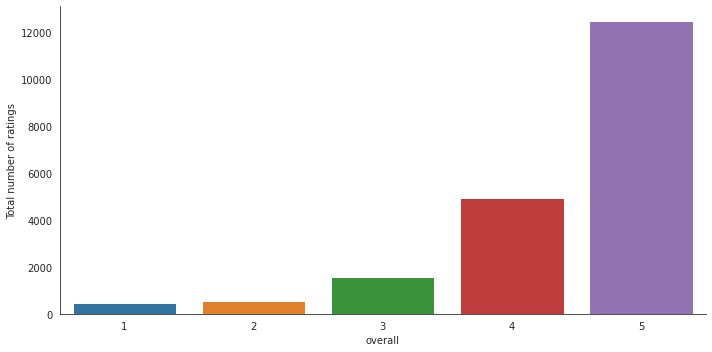

In [13]:
with sns.axes_style('white'):
    g= sns.factorplot('overall', data= df1, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")

# Users and Products

In [14]:
print('Number of unique users in Raw data =', df1['reviewerID'].nunique())
print('Number of unique products in Raw data =', df1['asin'].nunique())


Number of unique users in Raw data = 4664
Number of unique products in Raw data = 1217


In [15]:
most_rated= df1.groupby('reviewerID').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n', most_rated)

Top 10 users based on ratings: 
 reviewerID
A3OXHLG6DIBRW8    50
A1ODOGXEYECQQ8    40
A2R6RA8FRBS608    36
A3J3OCM6PPWNRY    35
A22CW0ZHY3NJH8    35
A3HPCRD9RX351S    29
A22I55P15NSAOX    29
A1PAGHECG401K1    29
ADLVFFE4VBT8      26
A1POFVVXUZR3IQ    25
dtype: int64


In [16]:
counts= df1.reviewerID.value_counts()
df1_final= df1[df1.reviewerID.isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items =', len(df1_final))
print('Number of unique users in the final data =', df1_final['asin'].nunique())
print('Number of unique products in the final data =', df1_final['reviewerID'].nunique())


Number of users who have rated 25 or more items = 1708
Number of unique users in the final data = 692
Number of unique products in the final data = 86


# Ratings Matrix

In [17]:
df1_matrix= df1_final.pivot(index= 'reviewerID', columns= 'asin', values= 'overall').fillna(0)
df1_matrix.head()

asin,B00000JBLH,B00000JBLU,B00000JBNX,B00000JBO8,B00000JFNV,B00000K3T0,B00002NDS2,B00002QUKW,B0000365QL,B00004SUJT,...,B00256R26C,B0025Z3J38,B00260S6LM,B00269ABT8,B0026I2HLO,B0026ICM1E,B0026RHV52,B0026T65Z2,B00275FO34,B0027CTFBO
reviewerID,,,,,,,,,,,,,,,,,,,,,
A17771LTRWSKQ5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
A18GJ9MYYO6GCQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
A1A9PD00UVHHVI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1AC1ZXX9IBCTT,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BJOHHLG0D965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
print('Shape of final_ratings_matrix: ', df1_matrix.shape)

Shape of final_ratings_matrix:  (86, 692)


In [19]:
train_data, test_data= train_test_split(df1_final, test_size= 0.3, random_state=0)
train_data.head()

,reviewerID,asin,overall
14109,A31Z48BHHUTB0P,B0012G9VNS,5
10326,A29QCPFDSDNNKQ,B000J07T0K,5
9118,A1ILWPH1GHUXE2,B000FDR47E,5
11445,A1PAGHECG401K1,B000Q2Y7JM,5
6916,A1ILWPH1GHUXE2,B0006HXAW2,4


In [20]:
print("Training Data Shape:", train_data.shape)
print("Testing Data Shape:", test_data.shape)

Training Data Shape: (1195, 3)
Testing Data Shape: (513, 3)


# 1. Building the Popularity Recommender Model:

In [23]:
train_data_grouped= train_data.groupby('asin').agg({'reviewerID':'count'}).reset_index()
train_data_grouped.rename(columns= {'reviewerID':'overall'}, inplace= True)
train_data_grouped.head(40)

,asin,overall
0,B00000JBLH,1
1,B00000JBLU,1
2,B00000JBNX,1
3,B00000JBO8,1
4,B00000JFNV,3
5,B00000K3T0,1
6,B00002NDS2,1
7,B00002QUKW,1
8,B00004VVIX,1
9,B00004YTPX,2


In [24]:

# Sorting the product based on the recommendation score
train_data_sort= train_data_grouped.sort_values(['overall', 'asin'], ascending= [0,1])

#Getting Recommendation Rank
train_data_sort['rank']= train_data_sort['overall'].rank(ascending=0, method= 'first')

# Getting top 5 Recommendations
popularity_recommendations= train_data_sort.head(5)
popularity_recommendations

,asin,overall,rank
387,B0010T3QT2,16,1.0
225,B0009F3P3U,15,2.0
319,B000MFHX3U,15,3.0
372,B000WU4H5C,12,4.0
565,B0027CTFBO,12,5.0


In [25]:
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [26]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

The list of recommendations for the userId: 10

     userId        asin  overall  rank
387      10  B0010T3QT2       16   1.0
225      10  B0009F3P3U       15   2.0
319      10  B000MFHX3U       15   3.0
372      10  B000WU4H5C       12   4.0
565      10  B0027CTFBO       12   5.0


The list of recommendations for the userId: 100

     userId        asin  overall  rank
387     100  B0010T3QT2       16   1.0
225     100  B0009F3P3U       15   2.0
319     100  B000MFHX3U       15   3.0
372     100  B000WU4H5C       12   4.0
565     100  B0027CTFBO       12   5.0


The list of recommendations for the userId: 150

     userId        asin  overall  rank
387     150  B0010T3QT2       16   1.0
225     150  B0009F3P3U       15   2.0
319     150  B000MFHX3U       15   3.0
372     150  B000WU4H5C       12   4.0
565     150  B0027CTFBO       12   5.0




# 2. Building a Collaborative Filtering Model

In [27]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,reviewerID,asin,overall
0,14109,A31Z48BHHUTB0P,B0012G9VNS,5
1,10326,A29QCPFDSDNNKQ,B000J07T0K,5
2,9118,A1ILWPH1GHUXE2,B000FDR47E,5
3,11445,A1PAGHECG401K1,B000Q2Y7JM,5
4,6916,A1ILWPH1GHUXE2,B0006HXAW2,4


In [28]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'reviewerID', columns ='asin', values = 'overall').fillna(0)
pivot_df.head()

asin,B00000JBLH,B00000JBLU,B00000JBNX,B00000JBO8,B00000JFNV,B00000K3T0,B00002NDS2,B00002QUKW,B0000365QL,B00004SUJT,...,B00256R26C,B0025Z3J38,B00260S6LM,B00269ABT8,B0026I2HLO,B0026ICM1E,B0026RHV52,B0026T65Z2,B00275FO34,B0027CTFBO
reviewerID,,,,,,,,,,,,,,,,,,,,,
A17771LTRWSKQ5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
A18GJ9MYYO6GCQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
A1A9PD00UVHHVI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1AC1ZXX9IBCTT,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BJOHHLG0D965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (86, 692)


In [30]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

asin,B00000JBLH,B00000JBLU,B00000JBNX,B00000JBO8,B00000JFNV,B00000K3T0,B00002NDS2,B00002QUKW,B0000365QL,B00004SUJT,...,B0025Z3J38,B00260S6LM,B00269ABT8,B0026I2HLO,B0026ICM1E,B0026RHV52,B0026T65Z2,B00275FO34,B0027CTFBO,user_index
reviewerID,,,,,,,,,,,,,,,,,,,,,
A17771LTRWSKQ5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0
A18GJ9MYYO6GCQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1
A1A9PD00UVHHVI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A1AC1ZXX9IBCTT,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A1BJOHHLG0D965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [31]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

asin,B00000JBLH,B00000JBLU,B00000JBNX,B00000JBO8,B00000JFNV,B00000K3T0,B00002NDS2,B00002QUKW,B0000365QL,B00004SUJT,...,B00256R26C,B0025Z3J38,B00260S6LM,B00269ABT8,B0026I2HLO,B0026ICM1E,B0026RHV52,B0026T65Z2,B00275FO34,B0027CTFBO
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)

In [34]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[ 9.42962691e-02  3.82610209e-02  2.14809414e-02  8.83254144e-02
   4.45459622e-02  2.71545835e-02 -3.91245294e-02 -1.47805853e-02
   9.98259218e-02  1.04748308e-01]
 [ 1.47583183e-02  5.23901551e-02  5.89816813e-02 -1.52710753e-02
  -1.12267868e-01 -1.43006906e-01 -4.52240052e-02 -3.24699795e-02
   7.90777170e-02  2.05875294e-01]
 [ 2.72089448e-02 -8.37479033e-02 -9.18738849e-02 -1.05768692e-01
  -1.79562930e-02 -4.56253358e-02 -5.40461639e-02  6.44068388e-02
   5.52746098e-02  6.32235186e-02]
 [-6.24186341e-02 -1.50949813e-02 -4.40582222e-02  3.99572688e-02
  -4.01620442e-02  3.47004464e-02  5.11399812e-02  3.83727214e-02
   7.75030082e-03  1.63053374e-02]
 [-3.67857357e-04 -6.22755834e-02  9.19774518e-02 -9.47729969e-02
   1.01503173e-01 -6.53248204e-02 -7.93479587e-02  1.25062707e-01
   4.29768579e-02  1.10086043e-01]
 [ 2.18524154e-02 -2.63049313e-03  7.62113189e-02  3.19805837e-02
  -3.87228167e-02 -5.16833887e-02 -2.21918514e-02  1.01987775e-01
   2.1798

In [35]:
print('Sigma: \n',sigma)

Sigma: 
 [26.46869509 26.66714667 26.99768884 27.72688912 28.87766432 29.13634535
 29.86795432 30.95385308 33.06794476 50.70401252]


In [36]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[26.46869509  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         26.66714667  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         26.99768884  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         27.72688912  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         28.87766432  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         29.13634535
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  29.86795432  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         30.95385308  0.          0.        ]
 [ 0.          0.          0.        

In [37]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[-0.02566886  0.04112741 -0.0251197  ...  0.01089577  0.00482775
   0.03589404]
 [ 0.01164823  0.02975841  0.07101624 ...  0.01970404 -0.01186805
   0.10096651]
 [ 0.01129869  0.01006211  0.02979369 ...  0.00606155  0.02625154
   0.05777159]
 ...
 [-0.01239627  0.02761043  0.01912384 ... -0.03079629  0.02215245
  -0.05342272]
 [ 0.00358482 -0.06199347  0.01126399 ...  0.01054445  0.00274376
   0.10129459]
 [ 0.01066427  0.01884486  0.03525365 ...  0.01479418  0.01095023
   0.12362896]]


In [38]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

asin,B00000JBLH,B00000JBLU,B00000JBNX,B00000JBO8,B00000JFNV,B00000K3T0,B00002NDS2,B00002QUKW,B0000365QL,B00004SUJT,...,B00256R26C,B0025Z3J38,B00260S6LM,B00269ABT8,B0026I2HLO,B0026ICM1E,B0026RHV52,B0026T65Z2,B00275FO34,B0027CTFBO
0,0.109396,0.039396,0.172764,0.023794,-0.022903,-0.020864,-0.092392,0.029458,0.029458,-0.065083,...,0.084543,0.238491,-0.133631,-0.024069,-0.314993,0.459498,-0.096504,0.245891,0.077217,0.926038
1,0.183199,-0.292038,0.446013,0.018919,0.227316,-0.032432,0.004999,-0.020418,-0.020418,-0.147974,...,0.272191,0.482125,-0.149838,-0.024817,-0.168364,0.959946,0.112201,0.143421,0.096841,2.462002
2,-0.142500,-0.187116,0.027078,0.050966,-0.014414,0.105314,-0.093916,0.029587,0.029587,-0.105732,...,0.213487,-0.271308,0.464678,-0.001539,0.023361,0.022248,0.254364,-0.132671,0.022123,0.724540
3,0.057107,0.059629,-0.017806,-0.001965,0.268329,0.033041,0.135267,-0.019364,-0.019364,0.064726,...,-0.019956,0.033097,0.597587,0.074462,0.132831,-0.012604,0.002482,-0.031609,0.037797,-0.394454
4,-0.074147,-0.112773,0.363328,0.035638,-0.134608,0.045009,-0.053303,0.192458,0.192458,-0.015532,...,0.145552,0.393710,-0.218450,-0.051752,0.203939,0.355369,-0.050668,-0.079110,0.156494,1.154639


In [39]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [40]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)    


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B0006SV7Q2                  0.0          1.000869
B00015YRCG                  0.0          0.629204
B00004Z5QO                  0.0          0.614252
B00260S6LM                  0.0          0.597587
B0009F3P3U                  0.0          0.591600


In [41]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)    


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
B00006IFKT                  0.0          1.256198
B0009F3P3U                  0.0          1.071851
B0006SV7Q2                  0.0          1.019673
B000093L25                  0.0          0.982581
B0010T3QT2                  0.0          0.840331


In [42]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)    


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B000E7D72C                  0.0          1.205474
B0010T3QT2                  0.0          0.864501
B0025Z3J38                  0.0          0.845794
B000093L22                  0.0          0.717753
B000FH1J6C                  0.0          0.709320


Due to collaborative filtering, all three users are given different recommendations based on their respective past behavior.

In [44]:
# Actual ratings given by the users
df1_matrix.head()

asin,B00000JBLH,B00000JBLU,B00000JBNX,B00000JBO8,B00000JFNV,B00000K3T0,B00002NDS2,B00002QUKW,B0000365QL,B00004SUJT,...,B00256R26C,B0025Z3J38,B00260S6LM,B00269ABT8,B0026I2HLO,B0026ICM1E,B0026RHV52,B0026T65Z2,B00275FO34,B0027CTFBO
reviewerID,,,,,,,,,,,,,,,,,,,,,
A17771LTRWSKQ5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
A18GJ9MYYO6GCQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
A1A9PD00UVHHVI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1AC1ZXX9IBCTT,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BJOHHLG0D965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# Average ACTUAL rating for each item
df1_matrix.mean().head()

asin
B00000JBLH    0.058140
B00000JBLU    0.174419
B00000JBNX    0.232558
B00000JBO8    0.023256
B00000JFNV    0.232558
dtype: float64

In [47]:
# Predicted ratings 
preds_df.head()

asin,B00000JBLH,B00000JBLU,B00000JBNX,B00000JBO8,B00000JFNV,B00000K3T0,B00002NDS2,B00002QUKW,B0000365QL,B00004SUJT,...,B00256R26C,B0025Z3J38,B00260S6LM,B00269ABT8,B0026I2HLO,B0026ICM1E,B0026RHV52,B0026T65Z2,B00275FO34,B0027CTFBO
0,0.109396,0.039396,0.172764,0.023794,-0.022903,-0.020864,-0.092392,0.029458,0.029458,-0.065083,...,0.084543,0.238491,-0.133631,-0.024069,-0.314993,0.459498,-0.096504,0.245891,0.077217,0.926038
1,0.183199,-0.292038,0.446013,0.018919,0.227316,-0.032432,0.004999,-0.020418,-0.020418,-0.147974,...,0.272191,0.482125,-0.149838,-0.024817,-0.168364,0.959946,0.112201,0.143421,0.096841,2.462002
2,-0.142500,-0.187116,0.027078,0.050966,-0.014414,0.105314,-0.093916,0.029587,0.029587,-0.105732,...,0.213487,-0.271308,0.464678,-0.001539,0.023361,0.022248,0.254364,-0.132671,0.022123,0.724540
3,0.057107,0.059629,-0.017806,-0.001965,0.268329,0.033041,0.135267,-0.019364,-0.019364,0.064726,...,-0.019956,0.033097,0.597587,0.074462,0.132831,-0.012604,0.002482,-0.031609,0.037797,-0.394454
4,-0.074147,-0.112773,0.363328,0.035638,-0.134608,0.045009,-0.053303,0.192458,0.192458,-0.015532,...,0.145552,0.393710,-0.218450,-0.051752,0.203939,0.355369,-0.050668,-0.079110,0.156494,1.154639


In [48]:
# Average PREDICTED rating for each item
preds_df.mean().head()

asin
B00000JBLH    0.044057
B00000JBLU    0.133457
B00000JBNX    0.204503
B00000JBO8    0.012420
B00000JFNV    0.133089
dtype: float64

In [50]:
rmse_df = pd.concat([df1_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(692, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
asin,,,
B00000JBLH,0.058140,0.044057,0
B00000JBLU,0.174419,0.133457,1
B00000JBNX,0.232558,0.204503,2
B00000JBO8,0.023256,0.012420,3
B00000JFNV,0.232558,0.133089,4


In [51]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.03441 



# Getting top-K(K=5) Recommendations:

In [52]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B000FH1J6C                  0.0          1.788029
B000MFHX3U                  0.0          1.707437
B0000DH8HQ                  0.0          1.660902
B00006IFKW                  0.0          1.445946
B00007FGS5                  0.0          1.324096


# Summary

* The Popularity-Based recommender model recommended the same set of products to the users as shown above due to it not being personalised for the user but rather being based in frequency counts as shown above for Reviewer ID's 10, 100 and 1000.

* The Collaborative Filtering-based model gave personalized recommendation for the users based on their respective past behaviors as shown above for Reviewer ID's 4, 6 and 8.

# References

[1] https://github.com/LaxmiChaudhary/Amzon-Product-Recommendation